## General network properties: Size as number of nodes and links

In [45]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import config
import dataframe_image as dfi
from config import LEVELS, INTERACTOMES_PATH, DATA_REACTOME_PATH, PATHWAY_GRAPHS_PATH
from lib.networks import get_interactomes, get_combinations, get_combinations_with_pathways
from lib.networks import get_multiindex
from lib.networks import get_sizes
import networkx as nx
from networkx import edge_boundary
import itertools
import random

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Initial working directory: C:\git\ProteoformNetworks\src\Python
New working directory: c:\git\ProteoformNetworks


In [12]:
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(DATA_REACTOME_PATH, INTERACTOMES_PATH)
interactomes = [*interactomes_no_sm.values(), *interactomes_with_sm.values(), *interactomes_with_unique_sm.values()]

Quering participants of all reactions for level genes...
Quering participants of all reactions for level proteins...
Quering participants of all reactions for level proteoforms...
Quering participants of all reactions for level sm...
Reading components of all complexes for level genes...
Reading components of all complexes for level proteins...
Reading components of all complexes for level proteoforms...
Reading components of all complexes for level sm...
Creating interaction network for  at genes level, method no_sm...
Finished creating interactome file for genes-no_sm
Creating interaction network for  at proteins level, method no_sm...
Finished creating interactome file for proteins-no_sm
Creating interaction network for  at proteoforms level, method no_sm...
Finished creating interactome file for proteoforms-no_sm
Creating interaction network for  at genes level, method with_sm...
Finished creating interactome file for genes-with_sm
Creating interaction network for  at proteins leve

In [13]:
index = get_multiindex()
num_interactions, num_entities, num_small_molecules = get_sizes(interactomes, index)
num_interactions

Small Molecules           Entity Level
Not Included              genes            366208
                          proteins         375770
                          proteoforms      590415
Included                  genes            451490
                          proteins         461665
                          proteoforms      681891
Reaction-Unique Included  genes            808212
                          proteins         823196
                          proteoforms     1047542
dtype: int64

In [14]:
# Calculate number of nodes of each type
df_sizes = pd.DataFrame({
    "Interactions": num_interactions,
    "Accessioned Entities": num_entities,
    "Small Molecules": num_small_molecules
}, index=index)
df_sizes.columns.name = "Sizes"
dfi.export(df_sizes, 'figures/interactome_num_nodes_by_type.png')
df_sizes

Sizes                                  Interactions  Accessioned Entities  \
Small Molecules          Entity Level                                       
Not Included             genes               366208                 10976   
                         proteins            375770                 11074   
                         proteoforms         590415                 14246   
Included                 genes               451490                 10976   
                         proteins            461665                 11074   
                         proteoforms         681891                 14246   
Reaction-Unique Included genes               808212                 10976   
                         proteins            823196                 11074   
                         proteoforms        1047542                 14246   

Sizes                                  Small Molecules  
Small Molecules          Entity Level                   
Not Included             genes                       0  
                         proteins                    0  
                         proteoforms                 0  
Included                 genes                    2057  
                         proteins                 2057  
                         proteoforms              2057  
Reaction-Unique Included genes                   29599  
                         proteins                29599  
                         proteoforms             29599

In [15]:
# Create a list with the number of genes, proteins, proteoforms, small molecules
num_nodes = [*df_sizes.loc[['Not Included']]["Accessioned Entities"], df_sizes.loc[['Included']]["Small Molecules"][0]]

# Create list with all levels:
node_types = [*LEVELS, "small molecules"]

# Create a list with the number of interactions without the small molecules
num_interactions_no_sm = df_sizes.loc[['Not Included']]["Interactions"]

num_interactions_with_sm = df_sizes.loc[['Included']]["Interactions"]

maxy = max([*num_interactions_with_sm, *num_interactions_no_sm])

maxy = 800000

C:\Users\luisp\AppData\Local\Temp\ipykernel_35028\703382627.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot2.set_xticklabels(LEVELS, rotation=45)
C:\Users\luisp\AppData\Local\Temp\ipykernel_35028\703382627.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot3.set_xticklabels(LEVELS, rotation=45)


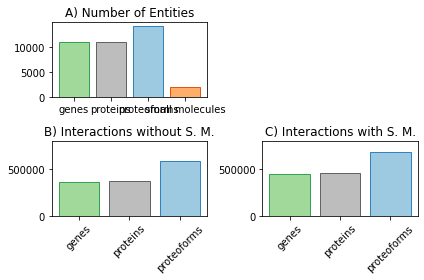

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from config import COLORS_BORDER

figure, axis = plt.subplots(1, 4)
# Placing the plots in the plane
plot1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
plot2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
plot3 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

# Plot number of nodes
plot1.bar(node_types, num_nodes, color=config.COLORS_FILL, edgecolor=COLORS_BORDER)
plot1.set_title('A) Number of Entities')

plt.xticks(rotation=90)

# Plot number of interactions without small molecules
plot2.bar(LEVELS, num_interactions_no_sm, color=config.COLORS_FILL, edgecolor=COLORS_BORDER)
plot2.set_title('B) Interactions without S. M.')
plot2.set_ylim([0, maxy])
plot2.set_xticklabels(LEVELS, rotation=45)

# Plot number of interactions with small molecules
plot3.bar(LEVELS, num_interactions_with_sm, color=config.COLORS_FILL, edgecolor=COLORS_BORDER)
plot3.set_title('C) Interactions with S. M.')
plot3.set_ylim([0, maxy])
plot3.set_xticklabels(LEVELS, rotation=45)

# Packing all the plots and displaying them
plt.tight_layout()
plt.show()

figure.savefig('figures/figure_4.png')
plt.close()

In [17]:
# Increase in nodes and interactions by changing from genes to proteins and then to proteoforms.


from lib.networks import get_increase_percentage
from config import genes, proteins, proteoforms

increase = get_increase_percentage(interactomes_no_sm[genes].number_of_nodes(),
                                   interactomes_no_sm[proteins].number_of_nodes())
print(f"There are {increase} % more nodes in the protein interactome than in the gene interactome.")# 

increase = get_increase_percentage(interactomes_no_sm[genes].number_of_edges(),
                                   interactomes_no_sm[proteins].number_of_edges())
print(f"There are {increase} % more interactions in the protein interactome than in the gene interactome.")

increase = get_increase_percentage(interactomes_no_sm[proteins].number_of_nodes(),
                                   interactomes_no_sm[proteoforms].number_of_nodes())
print(f"There are {increase} % more nodes in the proteoform interactome than in the protein interactome.")

increase = get_increase_percentage(interactomes_no_sm[proteins].number_of_edges(),
                                   interactomes_no_sm[proteoforms].number_of_edges())
print(f"There are {increase} % more interactions in the proteoform interactome than in the protein interactome.")

There are 0.88 % more nodes in the protein interactome than in the gene interactome.
There are 2.54 % more interactions in the protein interactome than in the gene interactome.
There are 22.27 % more nodes in the proteoform interactome than in the protein interactome.
There are 36.35 % more interactions in the proteoform interactome than in the protein interactome.


In [30]:
# Increase in nodes by adding small molecules

for l in [genes, proteoforms]:
    increase_generic = get_increase_percentage(
        interactomes_no_sm[l].number_of_nodes(),
        interactomes_with_sm[l].number_of_nodes()
    )
    print(f"In the {l} network, there is an increase of {interactomes_with_sm[l].number_of_nodes() - interactomes_no_sm[l].number_of_nodes()} nodes when adding small molecules, that is {increase_generic} % more.")

    increase_generic = get_increase_percentage(
        interactomes_no_sm[l].number_of_edges(),
        interactomes_with_sm[l].number_of_edges()
    )
    print(f"In the {l} network, there is an increase of {interactomes_with_sm[l].number_of_edges() - interactomes_no_sm[l].number_of_edges()} links when adding generic small molecules, that is {increase_generic} % more.")

    increase_unique = get_increase_percentage(
        interactomes_no_sm[l].number_of_nodes(),
        interactomes_with_unique_sm[l].number_of_nodes()
    )
    print(f"In the {l} network, there is an increase of {interactomes_with_unique_sm[l].number_of_nodes() - interactomes_no_sm[l].number_of_nodes()} nodes when adding reaction-unique small molecules, that is {increase_unique} % more.")

    increase_unique = get_increase_percentage(
        interactomes_no_sm[l].number_of_edges(),
        interactomes_with_unique_sm[l].number_of_edges()
    )
    print(f"In the {l} network, there is an increase of {interactomes_with_unique_sm[l].number_of_edges() - interactomes_no_sm[l].number_of_edges()} links when adding reaction-unique small molecules, that is {increase_unique} % more.")

increase_with_generic_sm = [get_increase_percentage(
        interactomes_no_sm[l].number_of_nodes(),
        interactomes_with_sm[l].number_of_nodes()
    ) for l in LEVELS]
percentage_generic_sm = [
    (interactomes_with_sm[l].number_of_nodes() - interactomes_no_sm[l].number_of_nodes()) / interactomes_with_sm[l].number_of_nodes()
    for l in LEVELS]
increase_with_unique_sm = [get_increase_percentage(
        interactomes_no_sm[l].number_of_nodes(),
        interactomes_with_unique_sm[l].number_of_nodes()
    ) for l in LEVELS]
percentage_unique_sm = [
    (interactomes_with_unique_sm[l].number_of_nodes() - interactomes_no_sm[l].number_of_nodes()) / interactomes_with_unique_sm[l].number_of_nodes()
    for l in LEVELS]

d = {
    "Increase of nodes with generic small molecules": increase_with_generic_sm,
    "Percentage of generic small molecule nodes": percentage_generic_sm,
    "Increase of nodes with unique small molecules": increase_with_unique_sm,
    "Percentage of unique small molecule nodes ": percentage_unique_sm
}

df_increase_sm = pd.DataFrame(data=d, index=LEVELS)
dfi.export(df_increase_sm, 'figures/interactome_size_increase.png')
df_increase_sm


In the genes network, there is an increase of 2057 nodes when adding small molecules, that is 15.78 % more.
In the genes network, there is an increase of 85282 links when adding generic small molecules, that is 18.89 % more.
In the genes network, there is an increase of 29599 nodes when adding reaction-unique small molecules, that is 72.95 % more.
In the genes network, there is an increase of 442004 links when adding reaction-unique small molecules, that is 54.69 % more.
In the proteoforms network, there is an increase of 2057 nodes when adding small molecules, that is 12.62 % more.
In the proteoforms network, there is an increase of 91476 links when adding generic small molecules, that is 13.42 % more.
In the proteoforms network, there is an increase of 29599 nodes when adding reaction-unique small molecules, that is 67.51 % more.
In the proteoforms network, there is an increase of 457127 links when adding reaction-unique small molecules, that is 43.64 % more.


,Increase of nodes with generic small molecules,Percentage of generic small molecule nodes,Increase of nodes with unique small molecules,Percentage of unique small molecule nodes
genes,15.78,0.16,72.95,0.73
proteins,15.67,0.16,72.77,0.73
proteoforms,12.62,0.13,67.51,0.68


In [19]:
from statistics import mean
from lib.dictionaries import read_dictionary_one_to_set

map_genes_to_proteins = read_dictionary_one_to_set(INTERACTOMES_PATH, "mapping_proteins_to_genes.tsv",
                                                   col_indices=(1, 0))
print(f"There are {len(map_genes_to_proteins.keys())} genes in the map.")

avg_proteins_per_gene = round(mean([len(map_genes_to_proteins[key]) for key in map_genes_to_proteins.keys()]), 2)
print(f"The average number of proteins per gene is {avg_proteins_per_gene}")

There are 10976 genes in the map.
The average number of proteins per gene is 1.01


In [20]:
map_proteins_to_proteoforms = read_dictionary_one_to_set(INTERACTOMES_PATH, "mapping_proteins_to_proteoforms.tsv",
                                                         col_indices=(0, 1))
print(f"There are {len(map_proteins_to_proteoforms.keys())} proteins in the map.")

avg_proteoforms_per_protein = round(
    mean([len(map_proteins_to_proteoforms[key]) for key in map_proteins_to_proteoforms.keys()]), 2)
print(f"The average number of proteoforms per protein is {avg_proteoforms_per_protein}")

There are 11074 proteins in the map.
The average number of proteoforms per protein is 1.29


In [55]:
# Get number of nodes with proteoform level information and number of connections among them
# For networks with only accessioned entities; i.e. without small molecules

nodes_uu = [node for node in interactomes_no_sm['proteoforms'].nodes if not any((c in {':', '-'}) for c in str(node))]
nodes_mm = [node for node in interactomes_no_sm['proteoforms'].nodes if any((c in {':', '-'}) for c in str(node))]

print(f"Nodes with not modified proteoforms {len(nodes_uu)}")
print(nodes_uu[1:5])

print(f"Nodes with modified proteoforms {len(nodes_mm)}")
print(nodes_mm[1:5])

edges_uu = edge_boundary(interactomes_no_sm['proteoforms'], nodes_uu, nodes_uu)
edges_um = edge_boundary(interactomes_no_sm['proteoforms'], nodes_uu, nodes_mm)
edges_mm = edge_boundary(interactomes_no_sm['proteoforms'], nodes_mm, nodes_mm)

num_edges_uu = len(list(edges_uu))
num_edges_um = len(list(edges_um))
num_edges_mm = len(list(edges_mm))

print(f"Total number of connections in the proteoform interactome: {interactomes_no_sm['proteoforms'].number_of_edges()}")


percentage = num_edges_uu * 100 / interactomes_no_sm['proteoforms'].number_of_edges()
print(f"Number of connections in the proteoform-centric network where proteoform level informaction is NOT available for both nodes: {num_edges_uu}, that is {percentage} % of all the connections.")

percentage = num_edges_um * 100 / interactomes_no_sm['proteoforms'].number_of_edges()
print(f"Number of connections in the proteoform-centric network where proteoform level informaction is available for one of the nodes: {num_edges_um}, that is {percentage} % of all the connections.")

percentage = num_edges_mm * 100 / interactomes_no_sm['proteoforms'].number_of_edges()
print(f"Number of connections in the proteoform-centric network where proteoform level informaction is available for both nodes: {num_edges_mm}, that is {percentage} % of all the connections.")

# for edge in random.sample(list(edges_mm), 50):
#     print(edge)

Nodes with not modified proteoforms 10813
['O60674;', 'P23458;', 'P29597;', 'P40189;']
Nodes with modified proteoforms 3433
['P40189-2;', 'O60674;00048:1007', 'P23458;00048:1034', 'P29597;00048:1054']
Total number of connections in the proteoform interactome: 590415
Number of connections in the proteoform-centric network where proteoform level informaction is NOT available for both nodes: 345253, that is 58.47632597410296 % of all the connections.
Number of connections in the proteoform-centric network where proteoform level informaction is available for one of the nodes: 101907, that is 17.26023220954752 % of all the connections.
Number of connections in the proteoform-centric network where proteoform level informaction is available for both nodes: 143255, that is 24.263441816349516 % of all the connections.


In [ ]:

subgraphs = dict()
subgraphs['mm'] = interactomes['proteoforms'].subgraph(nodes_mm).copy(as_view=False)
subgraphs['uu'] = interactomes['proteoforms'].subgraph(nodes_uu).copy(as_view=False)
subgraphs['um'] = nx.Graph()
subgraphs['um'].add_edges_from(edges_um)

print(f"Original interactome edges: {interactomes['proteoforms'].number_of_edges()}, original interactome nodes: {interactomes['proteoforms'].number_of_nodes()}")
print(f"mm: edges: {subgraphs['mm'].number_of_edges()}, vertices: {subgraphs['mm'].number_of_nodes()}" )
print(f"uu: edges: {subgraphs['uu'].number_of_edges()}, vertices: {subgraphs['uu'].number_of_nodes()}" )